## Aprendizado não supervisionado
### Aplicação do algorithm GMM para clusterização de dados

In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#GMM - Gaussian Mixture Model - Training
from sklearn.mixture import GaussianMixture
# Avaliando o modelo
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#Implementation of Kmeans from scratch and using sklearn
#Loading the required modules 
from scipy.spatial.distance import cdist
from sklearn.datasets import load_digits
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
from scipy.linalg import inv, det
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics.pairwise import cosine_similarity
import warnings

In [2]:
input_file = 'train.csv'
columns = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 
           'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 
           'n_cores', 'pc', 'px_height', 'px_width', 'ram', 
           'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 
           'wifi', 'price_range', 'id']

# Load the data
df = pd.read_csv(input_file)

In [3]:
# sns.scatterplot(x='battery_power', y='ram', hue='price_range', data=df)

In [5]:
# normalizing min max
# x_train = preprocessing.normalize(df)
features = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']
target = 'price_range'
x = df.loc[:, features].values
y = df.loc[:, target].values

# Normalize the data

# Min Max
x_minmax = MinMaxScaler().fit_transform(x)
normalized_minmax = pd.DataFrame(x_minmax, columns = features)
# normalized_minmax = pd.concat([normalized_minmax, df[[target]]], axis = 1)

# Z-Score
x_zscore = StandardScaler().fit_transform(x)
normalized_zscore = pd.DataFrame(x_zscore, columns = features)
# normalized_zscore = pd.concat([normalized_zscore, df[[target]]], axis = 1)


k_clusters = 13



In [6]:
def plot_samples(projected, labels, title):    
    fig = plt.figure()
    u_labels = np.unique(labels)
    for i in u_labels:
        plt.scatter(projected[labels == i , 0] , projected[labels == i , 1] , label = i,
                    edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('tab10', 10))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend()
    plt.title(title)
    plt.show()

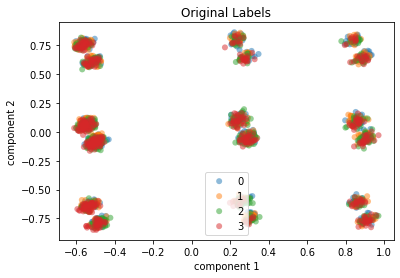

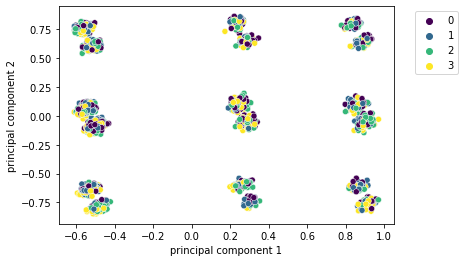

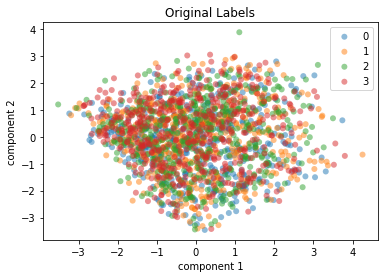

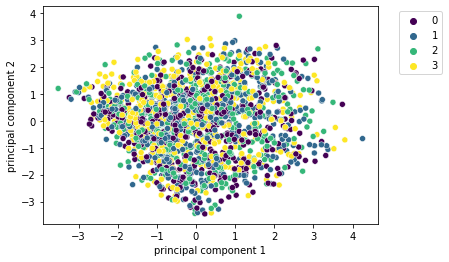

In [7]:
# PCA implementation
# Assuming 'x' is your feature set and 'df' is your original DataFrame

# Perform PCA with 2 components
def apply_pca(normalized):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(normalized)

    plot_samples(principalComponents, y, 'Original Labels')

    # Create a DataFrame with the principal components
    principal_breast_Df = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

    # Add the target variable to the principal component DataFrame
    principal_breast_Df[target] = df[target].values

    # Plot the scatter plot
    sns.scatterplot(x='principal component 1', y='principal component 2', hue=target, data=principal_breast_Df, palette='viridis')

    # Remove the target variable from the principal component DataFrame
    principal_breast_Df = principal_breast_Df.drop([target], axis=1)

    # Ajustar a posição da legenda
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    return principal_breast_Df
    

principal_breast_Df_minMax = apply_pca(normalized_minmax)

principal_breast_Df_zscore = apply_pca(normalized_zscore)

### SIMILARIDADE 
quão próximos ou distantes esses centroides estão uns dos outros no espaço de características.
### HOMOGENEIDADE
quão semelhantes são os tamanhos dos clusters.
### COEFICIENTE DA FORMA/SILHUETA
quão bem os objetos estão organizados em seus clusters.

In [35]:
def calc_gmm_metrics(data, labels_true, k_range):
    silhouette_scores = []
    homogeneity_scores = []
    similarity_scores = []

    for k in k_range:
        if k < 2:
            # Silhouette score cannot be calculated for k less than 2
            silhouette_scores.append(None)
            homogeneity_scores.append(None)
            similarity_scores.append(None)
            continue
        
        # Aplicar o modelo GMM
        gmm = GaussianMixture(n_components=k, random_state=0).fit(data)
        labels_pred = gmm.predict(data)
        
        centroids = gmm.means_
        
        # Calcular a similaridade entre os clusters
        # similarity = 0
        # for i in range(k):
        #     for j in range(i+1, k):
        #         similarity += np.linalg.norm(centroids[i] - centroids[j])
        # similarity_scores.append(similarity)
         # Calcular a similaridade de cosseno entre os centroids
        similarity_matrix = cosine_similarity(centroids)
        
        # Para cada par de centroids, somar as similaridades
        similarity = np.sum(np.tril(similarity_matrix, -1))
    min_score = np.min(similarity_scores)
    max_score = np.max(similarity_scores)
    # normalized_scores = [(score - min_score) / (max_score - min_score) for score in similarity_scores]
        
    for k in k_range:
        # Calcular Silhueta e Homogeneidade
        if len(set(labels_pred)) > 1:  # Validar se temos mais de um cluster
            silhouette = silhouette_score(data, labels_pred, metric='euclidean')
            homogeneity = homogeneity_score(labels_true, labels_pred)
            silhouette_scores.append(silhouette)
            homogeneity_scores.append(homogeneity)
        else:
            silhouette_scores.append(None)
            homogeneity_scores.append(None)

        print(f"""K={k}: Silhouette={silhouette if silhouette is not None else 'N/A'}, 
                Homogeneity={homogeneity if homogeneity is not None else 'N/A'}, 
                Similarity={similarity}""")

    return silhouette_scores, homogeneity_scores, similarity_scores

def normalize_minmax(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

def calc_gmm_distances(data, k_range):
    avg_distances = []
    
    for k in k_range:
        if k < 1:
            distances.append(None)
            continue

        # Aplicar o modelo GMM
        gmm = GaussianMixture(n_components=k, random_state=0).fit(data)
        
        # Obter os meios das componentes gaussianas
        means = gmm.means_
        
        # Atribuir cada ponto ao centro mais próximo e calcular a distância
        labels = gmm.predict(data)
        distances = np.zeros(len(data))
        
        for i, mean in enumerate(means):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                # Calcular a distância euclidiana do ponto até o centro do cluster
                distances[labels == i] = np.sqrt(np.sum((cluster_points - mean) ** 2, axis=1))
        
        # Calcular a distância média
        avg_distance = np.mean(distances)
        avg_distances.append(avg_distance)
        
    # Normalizar as distâncias entre 0 e 1
    valid_distances = [distance for distance in distances if distance is not None]
    
    normalized_distances = normalize_minmax(np.array(valid_distances))
    
    for k, distance in zip(k_range, normalized_distances):
        print(f"K={k}: Avg Distance={distance}")


# Exemplo de uso:
k_range = range(1, 13)  # Gama de K's a serem testados
# data =   # Dados normalizados
labels_true = y  # Rótulos verdadeiros

print("Min Max")
silhouette_scores_min_max, homogeneity_scores_min_max, similarity_scores_min_max = calc_gmm_metrics(normalized_minmax, labels_true, k_range)
avg_distances = calc_gmm_distances(normalized_minmax, k_range)

print()
print("Z-Score")
silhouette_scores_zscore, homogeneity_scores_zscore, similarity_scores_zscore = calc_gmm_metrics(normalized_zscore, labels_true, k_range)
avg_distances = calc_gmm_distances(normalized_zscore, k_range)

Min Max
K=1: Silhouette=0.08950552609426572, 
                Homogeneity=0.004578287120407195, 
                Similarity=54.4190940440558
K=2: Silhouette=0.08950552609426572, 
                Homogeneity=0.004578287120407195, 
                Similarity=54.4190940440558
K=3: Silhouette=0.08950552609426572, 
                Homogeneity=0.004578287120407195, 
                Similarity=54.4190940440558
K=4: Silhouette=0.08950552609426572, 
                Homogeneity=0.004578287120407195, 
                Similarity=54.4190940440558
K=5: Silhouette=0.08950552609426572, 
                Homogeneity=0.004578287120407195, 
                Similarity=54.4190940440558
K=6: Silhouette=0.08950552609426572, 
                Homogeneity=0.004578287120407195, 
                Similarity=54.4190940440558
K=7: Silhouette=0.08950552609426572, 
                Homogeneity=0.004578287120407195, 
                Similarity=54.4190940440558
K=8: Silhouette=0.08950552609426572, 
                Homogen

c:\Users\raulp\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


K=1: Avg Distance=0.6926155104932185
K=2: Avg Distance=0.34593596324673503
K=3: Avg Distance=0.3086313952743498
K=4: Avg Distance=0.672984841948071
K=5: Avg Distance=0.3167324258791071
K=6: Avg Distance=0.6178997355148349
K=7: Avg Distance=0.33811936748862986
K=8: Avg Distance=0.51718893064632
K=9: Avg Distance=0.7743476407098534
K=10: Avg Distance=0.6319961658999885
K=11: Avg Distance=0.7451488515260936
K=12: Avg Distance=0.3908668634774673

Z-Score
K=1: Silhouette=0.01703909164831989, 
                Homogeneity=0.012212883663558995, 
                Similarity=-2.122770612369891
K=2: Silhouette=0.01703909164831989, 
                Homogeneity=0.012212883663558995, 
                Similarity=-2.122770612369891
K=3: Silhouette=0.01703909164831989, 
                Homogeneity=0.012212883663558995, 
                Similarity=-2.122770612369891
K=4: Silhouette=0.01703909164831989, 
                Homogeneity=0.012212883663558995, 
                Similarity=-2.122770612369891
K=5: 

c:\Users\raulp\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


K=1: Avg Distance=0.42909163061072697
K=2: Avg Distance=0.293275800401106
K=3: Avg Distance=0.2884303296732818
K=4: Avg Distance=0.4453161562457199
K=5: Avg Distance=0.35306417403108786
K=6: Avg Distance=0.41354060041012125
K=7: Avg Distance=0.2389539114739041
K=8: Avg Distance=0.5096440943640708
K=9: Avg Distance=0.4637002422540399
K=10: Avg Distance=0.5444953982682725
K=11: Avg Distance=0.6356989763815867
K=12: Avg Distance=0.32119667895668447


In [9]:
def calc_silhouette(normalized, kmeans):
    # calculate the silhouette score
    silhouette_avg = silhouette_score(normalized, kmeans.labels_, metric='euclidean')
    print("The average silhouette_score is :", silhouette_avg)
    
# # calculate the silhouette score
# silhouette_avg = silhouette_score(normalized_minmax, kmeans.labels_, metric='euclidean')
# print("The average silhouette_score is :", silhouette_avg)

# # Add the cluster labels to the dataframe
# df['cluster'] = kmeans.labels_

print("Min Max")
calc_silhouette(normalized_minmax, kmeans_minmax)

print()
print("Z-Score")
calc_silhouette(normalized_zscore, kmeans_zscore)

Min Max


NameError: name 'kmeans_minmax' is not defined

In [ ]:
k_clusters_range = range(0, k_clusters)  # Start from 1 to 2, resulting in 2 to 3 clusters
def calc_silhouette(normalized, kmeans):
    fits = []
    scores = []
    for k in k_clusters_range:
        kmeans = KMeans(n_clusters=k+1, random_state=0, n_init=1).fit(normalized)
        fits.append(kmeans)
        labels = kmeans.labels_
        if len(set(labels)) > 1:  # Check if we have more than one cluster
            score = silhouette_score(normalized, labels, metric='euclidean')
            scores.append(score)
        else:
            scores.append(None)  # Or handle the case where there's only one cluster in some other way

    # Printing scores to verify output
    for idx, sc in enumerate(scores):
        print(f"Silhouette score for {idx+1} clusters: {sc}")
        
    return fits, scores
# print(fits)

print("Min Max")
fits_minmax, score_minmax = calc_silhouette(normalized_minmax, kmeans_minmax)

print()
print("Z-Score")
fits_zscore, score_zscore = calc_silhouette(normalized_zscore, kmeans_zscore)


Min Max
Silhouette score for 1 clusters: None
Silhouette score for 2 clusters: 0.11708448482288923
Silhouette score for 3 clusters: 0.07799722530571844
Silhouette score for 4 clusters: 0.07698917377944857
Silhouette score for 5 clusters: 0.08551868526701233
Silhouette score for 6 clusters: 0.08543064984181692
Silhouette score for 7 clusters: 0.092415491409952
Silhouette score for 8 clusters: 0.0822166317363745
Silhouette score for 9 clusters: 0.08456989050384103
Silhouette score for 10 clusters: 0.08204761908725769
Silhouette score for 11 clusters: 0.08021035431405846
Silhouette score for 12 clusters: 0.09029002378568898

Z-Score
Silhouette score for 1 clusters: None
Silhouette score for 2 clusters: 0.06771623890102013
Silhouette score for 3 clusters: 0.0657538495080212
Silhouette score for 4 clusters: 0.057508887748453946
Silhouette score for 5 clusters: 0.0538718665209512
Silhouette score for 6 clusters: 0.047828505369957586
Silhouette score for 7 clusters: 0.042483086573165296
Silho

In [ ]:
k_clusters_range = range(0, 13)  # Start from 1 to 2, resulting in 2 to 3 clusters

def calc_homogeneity_for_k_range(data, labels_true, k_range):
    homogeneity_scores = []

    for k in k_range:
        if k < 2:
            # K-Means não pode ser calculado para k menor que 2
            homogeneity_scores.append(None)
            continue
        
        # Aplicar o modelo KMeans
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(data)
        
        # Assegurar que labels_true e kmeans.labels_ são unidimensionais
        labels_true_flat = labels_true.ravel()  # Flatten labels_true se necessário
        labels_pred_flat = kmeans.labels_.ravel()  # Flatten kmeans.labels_ se necessário

        # Calcular a homogeneidade
        if len(set(labels_true_flat)) > 1 and len(set(labels_pred_flat)) > 1:
            score = homogeneity_score(labels_true_flat, labels_pred_flat)
            homogeneity_scores.append(score)
        else:
            # Não pode calcular homogeneidade se todos os dados estão no mesmo cluster
            homogeneity_scores.append(None)
        
        # Imprimir o score de homogeneidade para cada k
        print(f"Homogeneity score for k={k}: {score if score is not None else 'Not computable (only one cluster)'}")

    return homogeneity_scores

# Exemplo de uso:
print("Min Max")
homogeneity_scores_minmax = calc_homogeneity_for_k_range(normalized_minmax, y, k_clusters_range)
print()
print("Z-Score")
homogeneity_scores_zscore = calc_homogeneity_for_k_range(normalized_zscore, y, k_clusters_range)



Min Max
Homogeneity score for k=2: 0.0005737978593281727
Homogeneity score for k=3: 0.0003350118923452303
Homogeneity score for k=4: 0.0007662568069987252
Homogeneity score for k=5: 0.000636298764408066
Homogeneity score for k=6: 0.0012994466701632267
Homogeneity score for k=7: 0.002442982240176448
Homogeneity score for k=8: 0.0028436859117701935
Homogeneity score for k=9: 0.0033038658232361906
Homogeneity score for k=10: 0.003323856268286653
Homogeneity score for k=11: 0.0038131769597583138
Homogeneity score for k=12: 0.004171241007722024

Z-Score
Homogeneity score for k=2: 0.0005737978593281727
Homogeneity score for k=3: 0.0017762965282320875
Homogeneity score for k=4: 0.007369878216040587
Homogeneity score for k=5: 0.009361645216639862
Homogeneity score for k=6: 0.01014945321820945
Homogeneity score for k=7: 0.00838561214044396
Homogeneity score for k=8: 0.009797758798504131
Homogeneity score for k=9: 0.024312209450032936
Homogeneity score for k=10: 0.017927276557516417
Homogeneity 

In [ ]:
def plot_samples(projected, labels, title):    
    fig = plt.figure()
    u_labels = np.unique(labels)
    for i in u_labels:
        plt.scatter(projected[labels == i , 0] , projected[labels == i , 1] , label = i,
                    edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('tab10', 10))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.legend()
    plt.title(title)

def plot_silhouette(principal_breast_Df, fits):
    for i in range(0, k_clusters):
        # sns.scatterplot(data = normalized_minmax, x = 'battery_power', y = 'ram', hue = fits[i].labels_)
        sns.scatterplot(data=principal_breast_Df, x='principal component 1', y='principal component 2', hue=fits[i].labels_, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('tab20', 10), palette='deep')
        # plt.title(f'{i+1} clusters')
        plt.title('Clusters Labels K-Means')
        # plot_samples(principal_breast_Df, fits[i].labels_, f'{i+1} clusters')
        plt.show()

# print("Min Max")
# plot_silhouette(principal_breast_Df_minMax, fits_minmax)
# print()
# print("Z-Score")
# plot_silhouette(principal_breast_Df_zscore, fits_zscore)

In [ ]:
print ("Min Max")
sns.lineplot(x = k_clusters_range, y = score_minmax, label='Min Max')
print()
print ("Z-Score")
sns.lineplot(x = k_clusters_range, y = score_zscore, label='Z-Score')
plt.title('Elbow Method')
plt.legend()


Min Max


NameError: name 'k_clusters_range' is not defined

In [ ]:
# Treinando o modelo GMM
gmm = GaussianMixture(n_components=4, random_state=42, )
gmm.fit(X_train_minmax)

# Predizendo os clusters
train_clusters = gmm.predict(X_train_minmax)
test_clusters = gmm.predict(X_test_minmax)

print(classification_report(y_train, train_clusters))

# Avaliando o modelo

              precision    recall  f1-score   support

           0       0.27      0.28      0.27       349
           1       0.26      0.36      0.30       354
           2       0.27      0.28      0.27       352
           3       0.24      0.13      0.17       345

    accuracy                           0.26      1400
   macro avg       0.26      0.26      0.25      1400
weighted avg       0.26      0.26      0.25      1400



In [ ]:
# Configurar e treinar o modelo GMM
warnings.filterwarnings('ignore')
gm = GaussianMixture(n_components=4, random_state=42)
gm.fit(normalized_zscore)

# Previsão dos clusters
clusters = gm.predict(normalized_zscore)

# Exibir resultados
print(clusters)

#silhouete, homogeneidade e completude


[3 1 1 ... 0 2 2]


The similarity between: { 0 } the centroids and the problems objects is:  5.873300180710585
The similarity between: { 1 } the centroids and the problems objects is:  6.088125890190456
The similarity between: { 2 } the centroids and the problems objects is:  5.135073028711563
The similarity between: { 3 } the centroids and the problems objects is:  6.628958286975237
The similarity between: { 4 } the centroids and the problems objects is:  6.271778510592821
The similarity between: { 5 } the centroids and the problems objects is:  4.428393301306361
The similarity between: { 6 } the centroids and the problems objects is:  4.443401547527477
The similarity between: { 7 } the centroids and the problems objects is:  5.119852061092585
The similarity between: { 8 } the centroids and the problems objects is:  7.56734989673644
The similarity between: { 9 } the centroids and the problems objects is:  6.746260346081168
The similarity between: { 10 } the centroids and the problems objects is:  3.6552

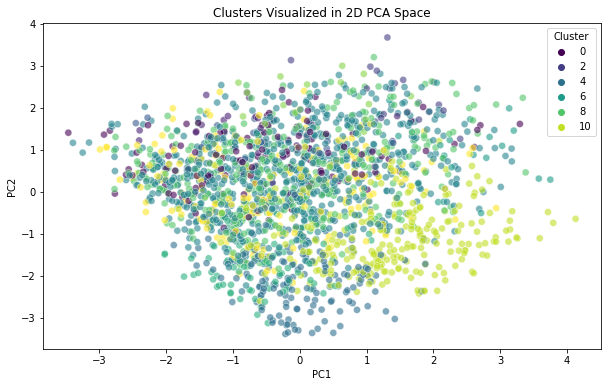

In [ ]:
# Load the dataset
input_file = 'train.csv'
features = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']
target = 'price_range'

df = pd.read_csv(input_file)

# Separate features and target
x = df[features].values
y = df[target].values

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Initialize and fit the GMM
n_components = 12  # Adjust based on your needs
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(x_normalized)

# Predict cluster assignments
clusters = gmm.predict(x_normalized)


# Compute clustering metrics
silhouette_avg = silhouette_score(x_normalized, clusters)
#Similarity between the clusters
similarity = []
for i in range(n_components):
    similarity.append(centroids[i].dot(centroids[i]))

for i in range(n_components):
    print("The similarity between: {", i, "} the centroids and the problems objects is: ", similarity[i])

#Homogeneity
homogeneity = homogeneity_score(y, clusters)


from sklearn.decomposition import PCA

# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_normalized)

# Create a DataFrame for plotting
df_pca = pd.DataFrame(x_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis', s=50, alpha=0.6)
plt.title('Clusters Visualized in 2D PCA Space')
plt.show()


Iteração 0: Log-Verossimilhança = -287.40676560050844
Iteração 1: Log-Verossimilhança = -273.2658426893647
Iteração 2: Log-Verossimilhança = -272.78370559963497
Iteração 3: Log-Verossimilhança = -272.30951626471904
Iteração 4: Log-Verossimilhança = -271.75249777275315
Iteração 5: Log-Verossimilhança = -271.1078520626695
Iteração 6: Log-Verossimilhança = -270.3877852048972
Iteração 7: Log-Verossimilhança = -269.6097352785409
Iteração 8: Log-Verossimilhança = -268.8036138322746
Iteração 9: Log-Verossimilhança = -268.0378348965584
Iteração 10: Log-Verossimilhança = -267.4099244187731
Iteração 11: Log-Verossimilhança = -266.96320583058747
Iteração 12: Log-Verossimilhança = -266.6562712099135
Iteração 13: Log-Verossimilhança = -266.4318901948097
Iteração 14: Log-Verossimilhança = -266.258140324342
Iteração 15: Log-Verossimilhança = -266.123788892862
Iteração 16: Log-Verossimilhança = -266.0248240793272
Iteração 17: Log-Verossimilhança = -265.9560186558995
Iteração 18: Log-Verossimilhança = 

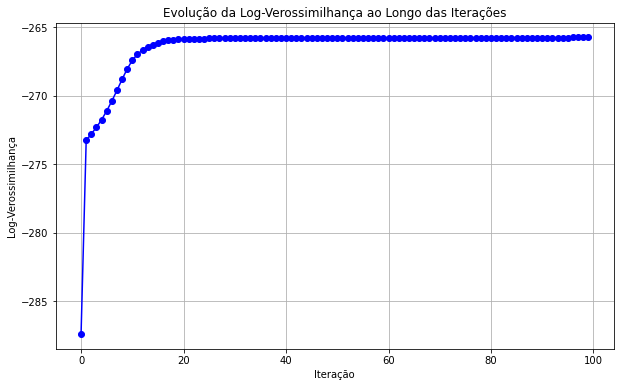

In [ ]:
# Defina a função para calcular a densidade gaussiana
def gaussian(X, mu, cov):
    D = X.shape[1]
    X_centered = X - mu
    cov_inv = inv(cov)
    det_cov = det(cov)
    
    # Computa a densidade gaussiana
    normalization_constant = np.sqrt((2 * np.pi) ** D * det_cov)
    exponent = -0.5 * np.sum(X_centered @ cov_inv * X_centered, axis=1)
    
    return np.exp(exponent) / normalization_constant

# Função para inicializar clusters
def initialize_clusters(X, n_clusters):
    clusters = []
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

# Função para o passo de expectativa
def expectation_step(X, clusters):
    global gamma_nk, totals
    N = X.shape[0]
    K = len(clusters)
    totals = np.zeros((N, 1), dtype=np.float64)
    gamma_nk = np.zeros((N, K), dtype=np.float64)
    
    for k, cluster in enumerate(clusters):
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
    
        gamma_nk[:, k] = (pi_k * gaussian(X, mu_k, cov_k)).ravel()
    
    totals = np.sum(gamma_nk, 1)
    gamma_nk /= np.expand_dims(totals, 1)

# Função para o passo de maximização
def maximization_step(X, clusters):
    global gamma_nk
    N = float(X.shape[0])
  
    for k, cluster in enumerate(clusters):
        gamma_k = np.expand_dims(gamma_nk[:, k], 1)
        N_k = np.sum(gamma_k, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_k * X, axis=0) / N_k
        cov_k = (gamma_k * (X - mu_k)).T @ (X - mu_k) / N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

# Função para obter a verossimilhança
def get_likelihood(X, clusters):
    global gamma_nk, totals
    sample_likelihoods = np.log(totals)
    return np.sum(sample_likelihoods), sample_likelihoods

# Inicialize clusters
n_clusters = 3
X = np.random.randn(100, 2)  # Dados de exemplo, substitua pelo seu conjunto de dados
clusters = initialize_clusters(X, n_clusters)

# Armazena a log-verossimilhança para cada iteração
log_likelihoods = []

# Execução do algoritmo EM
for iteration in range(100):  # Número de iterações
    expectation_step(X, clusters)
    maximization_step(X, clusters)
    likelihood, _ = get_likelihood(X, clusters)
    log_likelihoods.append(likelihood)
    print(f"Iteração {iteration}: Log-Verossimilhança = {likelihood}")

# Plotar o gráfico da log-verossimilhança
plt.figure(figsize=(10, 6))
plt.plot(range(len(log_likelihoods)), log_likelihoods, marker='o', linestyle='-', color='b')
plt.title('Evolução da Log-Verossimilhança ao Longo das Iterações')
plt.xlabel('Iteração')
plt.ylabel('Log-Verossimilhança')
plt.grid(True)
plt.show()




[0.08360954 0.08088729]
(2001, 22)
(2000, 2)
[1.]
[[-2.84217094e-17  6.62803146e-17]]


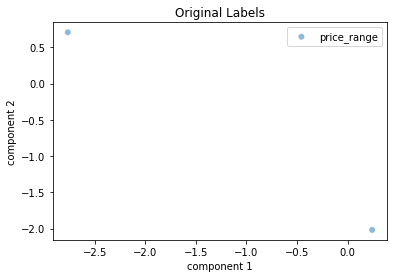

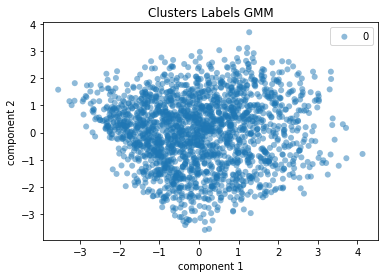

[0.42609073 0.57390927]
[[ 1.01334183  0.52161007]
 [-0.75234116 -0.38726194]]


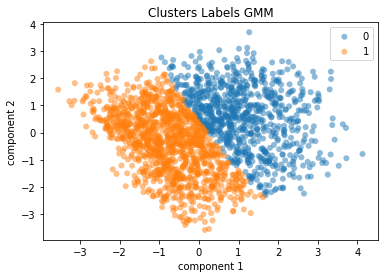

[0.29151    0.38945505 0.31903495]
[[ 0.18557814 -1.42721307]
 [-0.99970021  0.33860045]
 [ 1.05079526  0.89074011]]


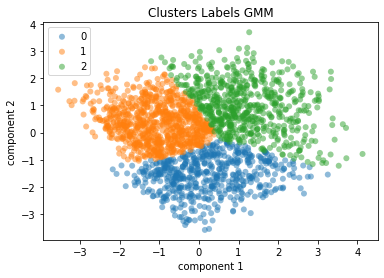

[0.29372023 0.31373751 0.25484855 0.13769371]
[[-1.16802668  0.48343508]
 [ 0.77117566  0.99956657]
 [-0.41838164 -1.22793694]
 [ 1.50878564 -1.03605499]]


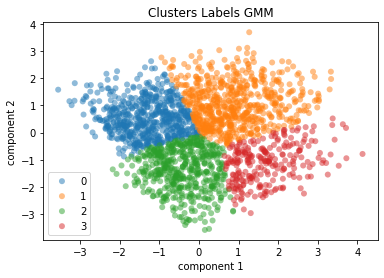

[0.24254743 0.19777543 0.25092964 0.14620999 0.16253752]
[[-0.44197671 -0.17941584]
 [-1.44646929  0.77474123]
 [ 0.87925009  1.22620398]
 [ 1.47552541 -0.88039827]
 [-0.26510839 -1.77605651]]


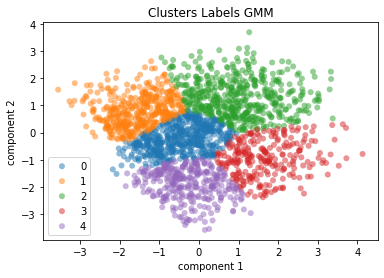

[0.17581089 0.2061569  0.13563143 0.14690939 0.13573908 0.19975232]
[[-0.61179888 -1.49871284]
 [ 0.0750233   0.07807883]
 [ 1.34766612 -1.31627694]
 [-0.01023059  1.48919887]
 [ 1.59774043  0.94080833]
 [-1.53221949  0.39769405]]


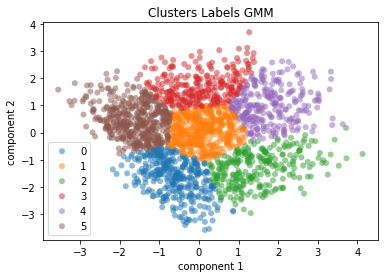

[0.19778555 0.13234353 0.13049947 0.11386691 0.17900751 0.10892075
 0.13757627]
[[ 0.20385625  0.17596636]
 [ 0.12434595  1.55851874]
 [-0.06501284 -1.85753154]
 [ 1.70762448  1.02088018]
 [-1.55598061  0.62169538]
 [ 1.58426763 -1.14177794]
 [-0.9940769  -0.74014145]]


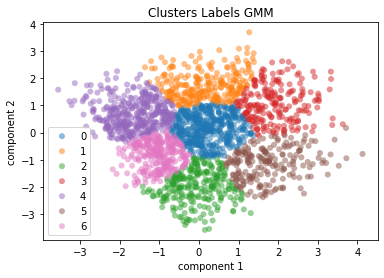

[0.13223962 0.17291003 0.12154349 0.14495997 0.09021137 0.07593557
 0.12927303 0.13292692]
[[-0.61570886 -1.67675738]
 [ 0.38146694  0.09587228]
 [-1.81316043  0.63938906]
 [-0.39910085  1.17288357]
 [ 0.84917419 -1.62316121]
 [ 1.96688159 -0.67607185]
 [-0.99258169 -0.2686951 ]
 [ 1.47483855  1.42877205]]


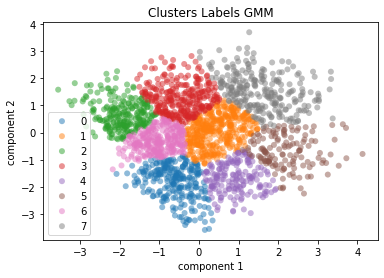

[0.11009306 0.17608541 0.1038397  0.10596642 0.1117416  0.12297947
 0.06416575 0.07818656 0.12694202]
[[-1.92915769  0.42142808]
 [ 0.38149604  0.16823443]
 [ 1.12356409 -1.40060202]
 [ 1.48831471  1.5715105 ]
 [-0.86839041  0.85263369]
 [-0.40308811 -1.86915331]
 [ 2.12826791 -0.12879666]
 [-0.01376638  1.49473177]
 [-0.92994914 -0.56025541]]


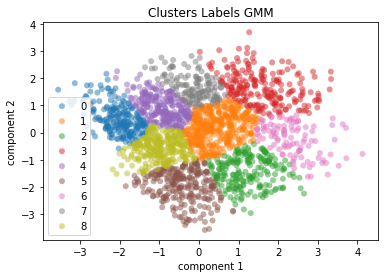

[0.13789726 0.08105715 0.06593664 0.08634539 0.1088631  0.09898615
 0.12919457 0.06349916 0.09797908 0.13024151]
[[-0.08945838  0.37606051]
 [ 1.87072317  1.0069292 ]
 [ 2.08668976 -0.8119323 ]
 [-0.45689053 -2.03575431]
 [ 0.73417084  1.53733091]
 [ 0.60523634 -0.4225492 ]
 [-1.83002846  0.4053736 ]
 [ 0.91746642 -1.78069318]
 [-0.87652898  1.30370193]
 [-0.86930467 -0.74269406]]


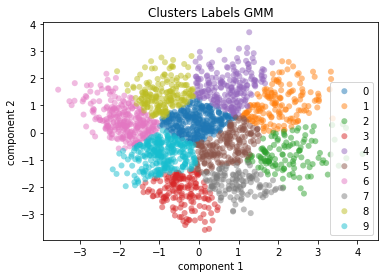

[0.12635952 0.13887214 0.10667445 0.10734883 0.09288641 0.09665029
 0.06408152 0.05299467 0.09261615 0.0773897  0.04412632]
[[-0.03961027 -0.15787627]
 [-0.69057771  1.07835538]
 [ 0.81229598  0.58042788]
 [-1.22655332 -0.3097731 ]
 [ 1.22974841 -1.27332636]
 [-0.72034983 -1.49629449]
 [ 0.09729012 -2.24256798]
 [ 2.11310623  1.2509107 ]
 [-1.98401904  0.62433233]
 [ 0.80170719  1.85043344]
 [ 2.37523927 -0.43483265]]


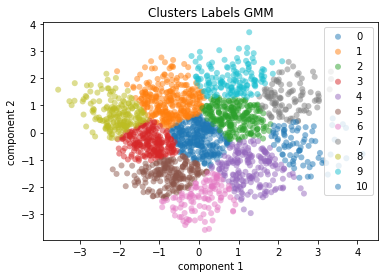

[0.09050572 0.08921559 0.10009342 0.09702427 0.08644863 0.10784803
 0.0572774  0.08760561 0.05783413 0.08232736 0.09475403 0.04906582]
[[ 0.67179575  1.72245388]
 [-0.75153544 -1.54049174]
 [-1.26579824 -0.3190595 ]
 [ 0.92542887  0.40998995]
 [-2.02693514  0.61928506]
 [-0.1550668   0.49688524]
 [ 2.20166315 -0.69153659]
 [ 1.02704921 -1.45926646]
 [ 2.12914125  1.22425499]
 [-0.12597767 -0.49124421]
 [-0.9428459   1.26750552]
 [-0.08972104 -2.37306746]]


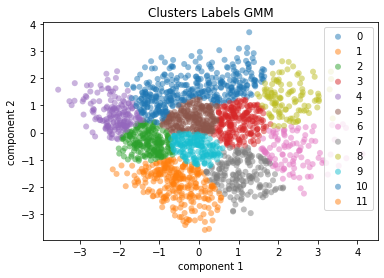

In [ ]:
def show_digitsdataset(digits):
    fig = plt.figure(figsize=(6, 6))  # figure size in inches
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(64):
        ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
        ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
        # label the image with the target value
        ax.text(0, 7, str(digits.target[i]))

    #fig.show()

def plot_samples(projected, labels, title):    
    fig = plt.figure()
    u_labels = np.unique(labels)
    for i in u_labels:
        plt.scatter(projected[labels == i , 0] , projected[labels == i , 1] , label = i,
                    edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('tab10', 10))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.legend()
    plt.title(title)

target = 'price_range'

digits = pd.read_csv(input_file, names=columns)


x = digits.loc[:, features].values
y = digits.loc[:,[target]].values

#Transform the data using PCA
pca = PCA(2)
projected = pca.fit_transform(x_zscore)
print(pca.explained_variance_ratio_)
print(digits.shape)
print(projected.shape)    
plot_samples(projected, target, 'Original Labels') 

for i in range(1, n_components+1):
    #Applying sklearn GMM function
    gm  = GaussianMixture(i).fit(projected)
    print(gm.weights_)
    print(gm.means_)
    x = gm.predict(projected)

    #Visualize the results sklearn
    plot_samples(projected, x, 'Clusters Labels GMM')

    plt.show()